In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding, LocallyLinearEmbedding, Isomap, TSNE
import umap
import GPy
import seaborn as sns

import imp

from ikd import utils, core, evaluate, datasets
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)

<module 'ikd.datasets' from '/storage/scratch1/1/cli726/ikd/ikd/ikd/datasets.py'>

## Specific trial

### GP

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


Too many remaining indices, use nearest neighbors to find all cliques for every points
Clique threshold: 0.3, number of cliques: 1000


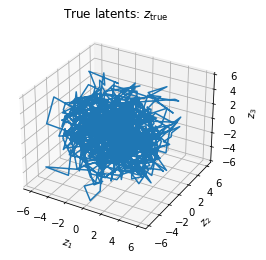

<Figure size 432x288 with 0 Axes>

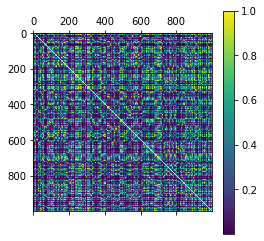

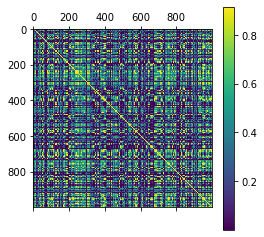

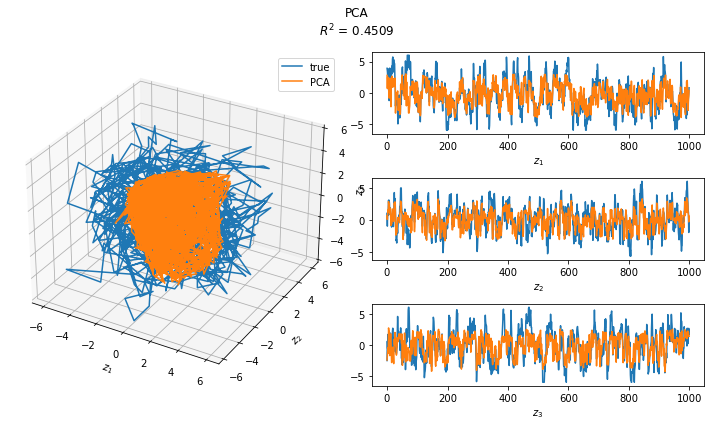

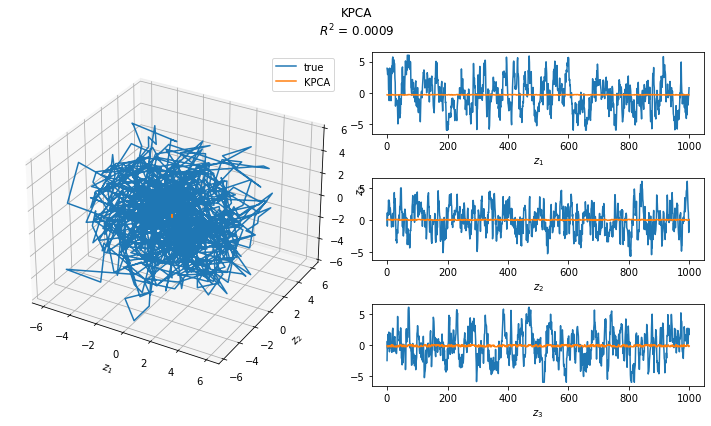

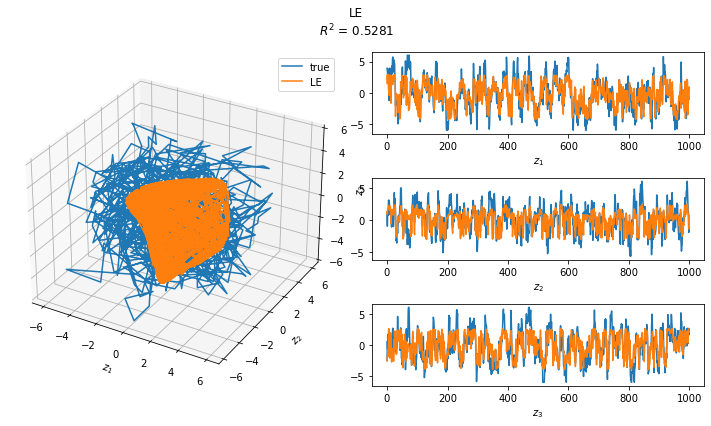

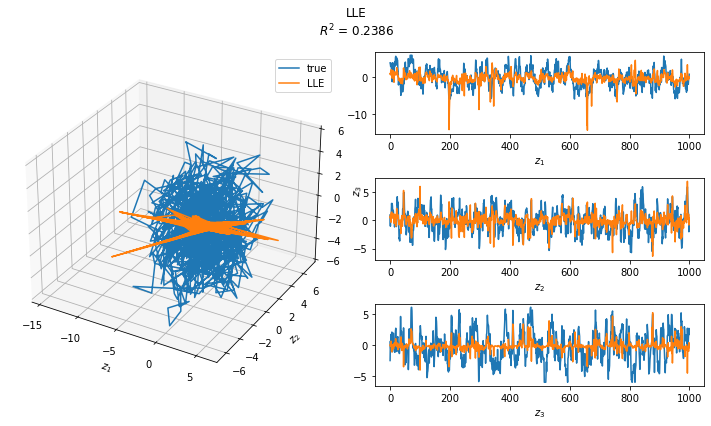

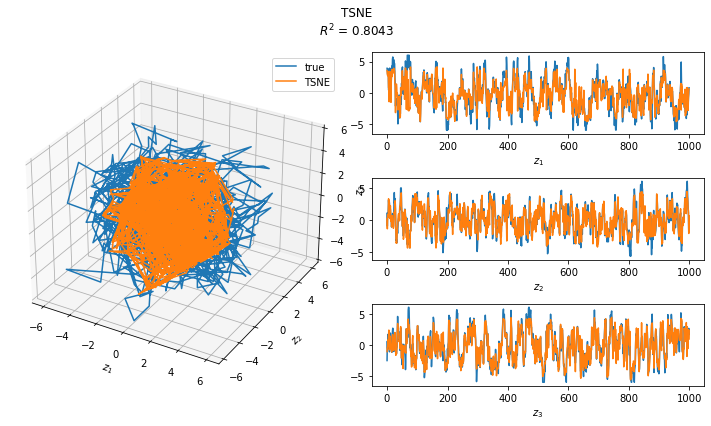

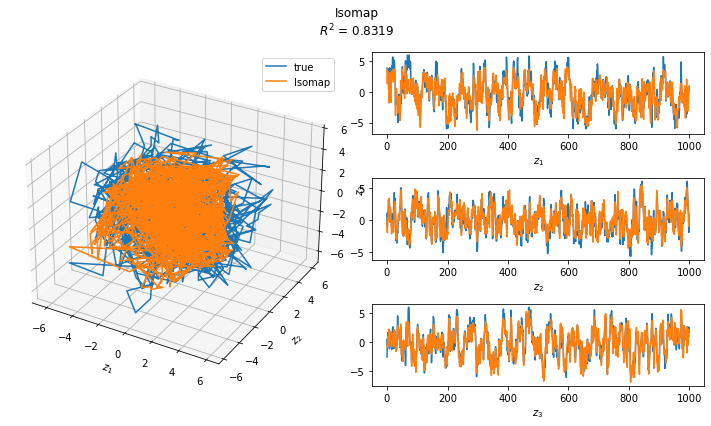

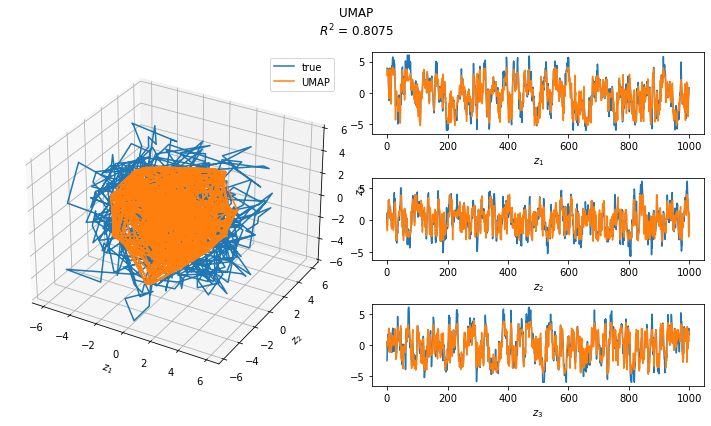

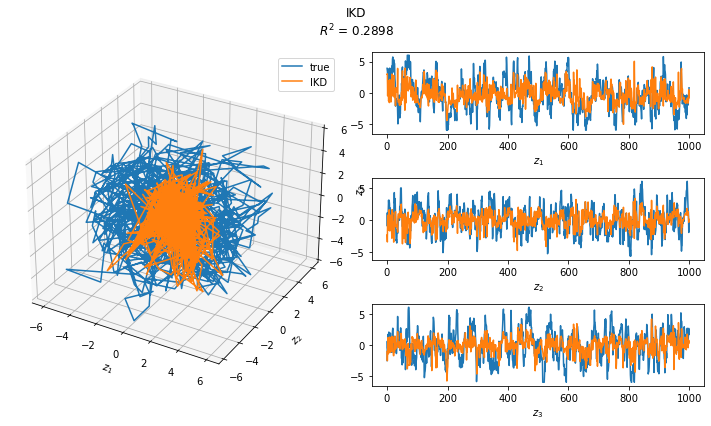

In [83]:
d_latent = 3
n_points = 1000
d_observation = 10
seed = 22
rng = np.random.default_rng(seed=seed)
z_true = datasets.generate_latent_from_prior(d_latent, n_points, kernel='autoregressive', variance=6, length_scale=5, bound=6, seed=seed)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.plot(z_true[:, 0], z_true[:, 1], z_true[:, 2])
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
plt.title("True latents: $z_\\mathrm{true}$")

cov_true = utils.kernel_cov_generator(z_true, length_scale=3)
plt.figure()
plt.matshow(cov_true)
plt.colorbar()

x = datasets.gaussian_process_generator(cov_true, d_observation, seed=seed) + rng.normal(scale=0.05, size=(n_points, d_observation))
cov_samp = np.cov(x)
variance_samp = np.mean(cov_samp) * 3.5
variance_samp = np.mean(np.diagonal(cov_samp))
cov_samp_th = utils.filt_cov_samp(cov_samp, variance_samp)

plt.matshow(cov_samp_th)
plt.colorbar()

z_pca = PCA(n_components=d_latent).fit_transform(x) # PCA
evaluate.compare_latents(z_true, utils.align(z_true, z_pca), "PCA")

z_kpca = KernelPCA(n_components=d_latent, kernel='sigmoid').fit_transform(x) # kernel PCA
evaluate.compare_latents(z_true, utils.align(z_true, z_kernel_pca), "KPCA")

z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x) # Laplacian eigenmaps
evaluate.compare_latents(z_true, utils.align(z_true, z_le), "LE")

z_lle = LocallyLinearEmbedding(n_components=d_latent).fit_transform(x) # Locally linear embedding
evaluate.compare_latents(z_true, utils.align(z_true, z_lle), "LLE")

z_tsne = TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(x) # TSNE
evaluate.compare_latents(z_true, utils.align(z_true, z_tsne), "TSNE")

z_isomap = Isomap(n_components=d_latent).fit_transform(x) # Isomap
evaluate.compare_latents(z_true, utils.align(z_true, z_isomap), "Isomap")

z_umap = umap.UMAP(n_components=d_latent, random_state=42).fit_transform(x) #UMAP
evaluate.compare_latents(z_true, utils.align(z_true, z_umap), "UMAP")

z_ikd = core.ikd_blockwise(cov_samp_th, d_latent, variance=variance_samp, clique_th_or_d_observation=d_observation)
evaluate.compare_latents(z_true, utils.align(z_true, z_ikd), "IKD")

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s16  0002   8.093332e+03   6.274693e+06 
    03s27  0041  -5.423713e+03   1.376533e+06 
    09s48  0119  -8.221811e+03   1.368057e+05 
    29s19  0366  -9.456105e+03   1.674879e+04 
    32s37  0405  -9.532778e+03   1.700818e+04 
 01m20s09  1002  -1.017484e+04   7.255134e+04 
Runtime:  01m20s09
Optimization status: Maximum number of f evaluations reached



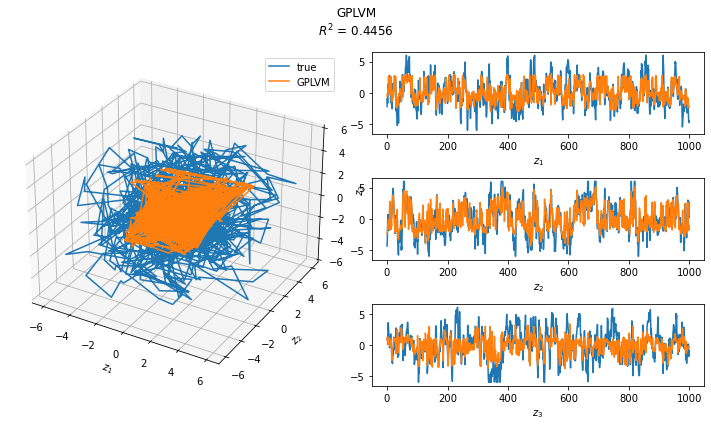

In [27]:
m_gplvm = GPy.models.GPLVM(x, d_latent, kernel=GPy.kern.RBF(d_latent, variance=1, lengthscale=1))
m_gplvm.likelihood.variance = 1.
m_gplvm.optimize(max_iters=1e3, messages=1)
z_gplvm = m_gplvm.X.values
evaluate.compare_latents(z_true, utils.align(z_true, z_gplvm), "GPLVM")

### sin

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


Too many remaining indices, use nearest neighbors to find all cliques for every points
Clique threshold: 0.3, number of cliques: 1000


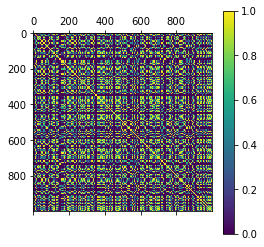

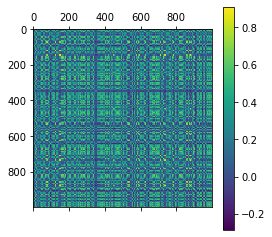

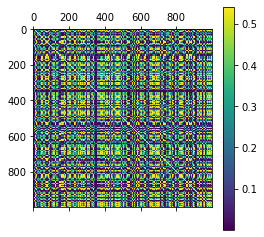

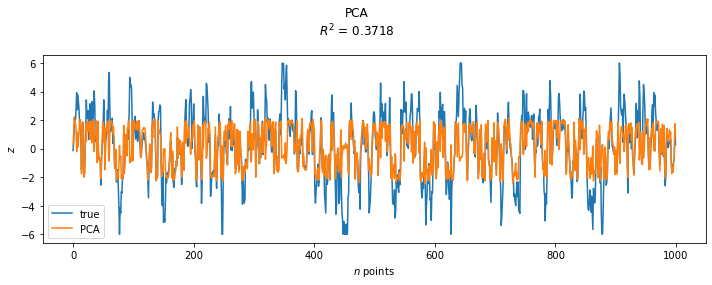

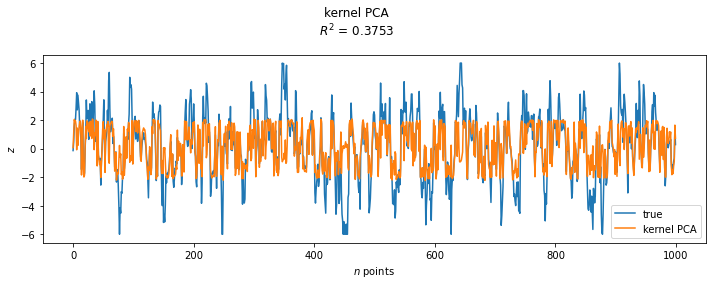

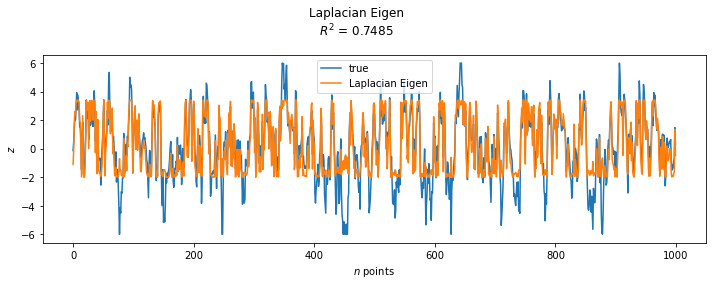

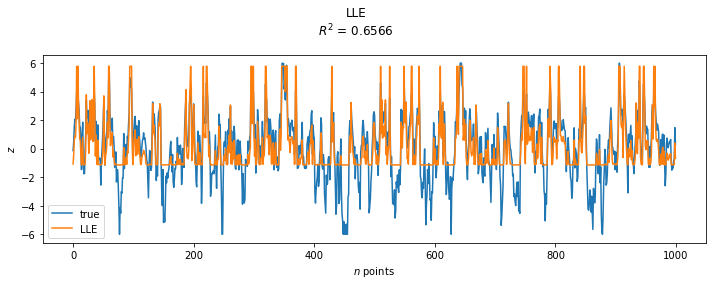

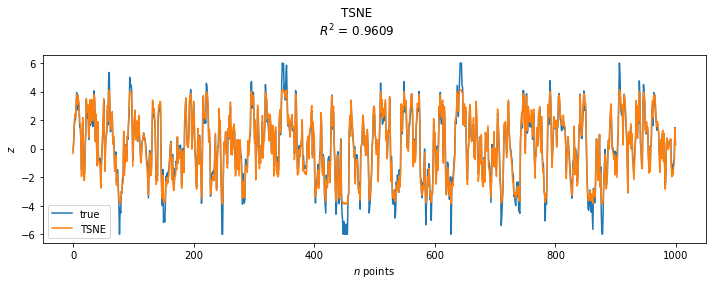

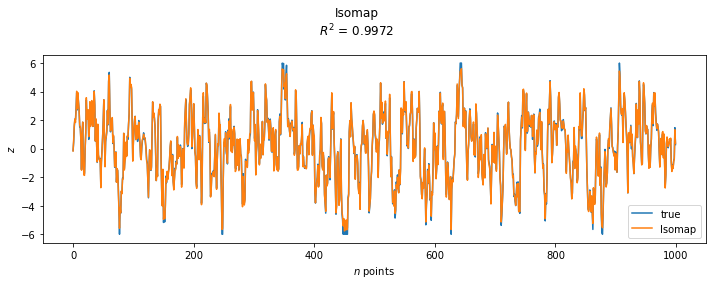

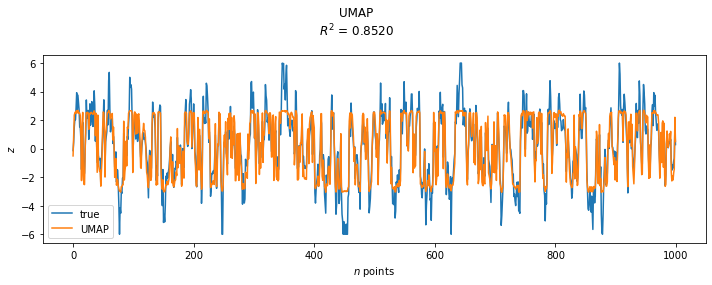

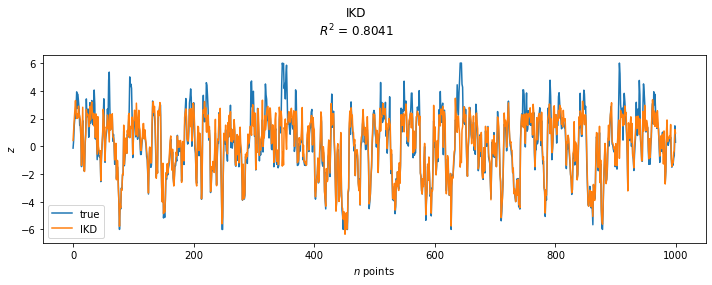

In [44]:
d_latent = 1
n_points = 1000
d_observation = 10
seed = 0
rng = np.random.default_rng(seed=seed)
z_true = datasets.generate_latent_from_prior(d_latent, n_points, kernel='autoregressive', variance=6, length_scale=5, bound=6, seed=seed)
plt.matshow(utils.kernel_cov_generator(z_true))
plt.colorbar()
omega = rng.uniform(low=-1, high=1, size=(d_observation, d_latent))
phi = rng.uniform(low=-np.pi, high=np.pi, size=(1, d_observation))
x = np.sin(z_true @ omega.T + phi) + rng.normal(scale=0.1, size=(n_points, d_observation))
cov_samp = np.cov(x)
plt.matshow(cov_samp)
plt.colorbar()
variance_samp = np.mean(cov_samp) * 2
variance_samp = np.mean(np.diagonal(cov_samp))
cov_samp_th = utils.filt_cov_samp(cov_samp, variance_samp)

plt.matshow(cov_samp_th)
plt.colorbar()

z_pca = PCA(n_components=d_latent).fit_transform(x)
evaluate.compare_latents(z_true, utils.align(z_true, z_pca), "PCA")

z_kernel_pca = KernelPCA(n_components=d_latent, kernel='cosine').fit_transform(x) # kernel PCA
evaluate.compare_latents(z_true, utils.align(z_true, z_kernel_pca), "KPCA")

z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x) # Laplacian eigenmaps
evaluate.compare_latents(z_true, utils.align(z_true, z_le), "LE")

z_lle = LocallyLinearEmbedding(n_components=d_latent).fit_transform(x) # Locally linear embedding
evaluate.compare_latents(z_true, utils.align(z_true, z_lle), "LLE")

z_tsne = TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(x) # TSNE
evaluate.compare_latents(z_true, utils.align(z_true, z_tsne), "TSNE")

z_isomap = Isomap(n_components=d_latent).fit_transform(x) # Isomap
evaluate.compare_latents(z_true, utils.align(z_true, z_isomap), "Isomap")

z_umap = umap.UMAP(n_components=d_latent, random_state=42).fit_transform(x) #UMAP
evaluate.compare_latents(z_true, utils.align(z_true, z_umap), "UMAP")

z_ikd = core.ikd_blockwise(cov_samp_th, d_latent, variance=variance_samp, clique_th_or_d_observation=0.3)
evaluate.compare_latents(z_true, utils.align(z_true, z_ikd), "IKD")

### Gaussain bump

In [ ]:
d_latent = 2
n_points = 1000
d_observation = 10
seed = 22
rng = np.random.default_rng(seed=seed)
z_true = datasets.generate_latent_from_prior(d_latent, n_points, kernel='autoregressive', variance=6, length_scale=5, bound=6, seed=seed)
plt.plot(z_true[:, 0], z_true[:, 1])
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('$z_{\\mathrm{true}}$')

cov_true = utils.kernel_cov_generator(z_true)
plt.figure()
plt.matshow(cov_true)
plt.colorbar()

x = datasets.gaussian_bump_generator(z_true, 100, d_observation, area=6, variance=20, length_scale=1, seed=seed) + rng.normal(scale=0.05, size=(n_points, d_observation))
cov_samp = np.cov(x)
variance_samp = np.mean(np.diagonal(cov_samp))
cov_samp_th = utils.filt_cov_samp(cov_samp, variance_samp)

plt.matshow(cov_samp_th)
plt.colorbar()

z_pca = PCA(n_components=d_latent).fit_transform(x) # PCA
evaluate.compare_latents(z_true, utils.align(z_true, z_pca), "PCA")

z_kernel_pca = KernelPCA(n_components=d_latent, kernel='sigmoid').fit_transform(x) # kernel PCA
evaluate.compare_latents(z_true, utils.align(z_true, z_kernel_pca), "KPCA")

z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x) # Laplacian eigenmaps
evaluate.compare_latents(z_true, utils.align(z_true, z_le), "LE")

z_lle = LocallyLinearEmbedding(n_components=d_latent).fit_transform(x) # Locally linear embedding
evaluate.compare_latents(z_true, utils.align(z_true, z_lle), "LLE")

z_tsne = TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(x) # TSNE
evaluate.compare_latents(z_true, utils.align(z_true, z_tsne), "TSNE")

z_isomap = Isomap(n_components=d_latent).fit_transform(x) # Isomap
evaluate.compare_latents(z_true, utils.align(z_true, z_isomap), "Isomap")

z_umap = umap.UMAP(n_components=d_latent, random_state=42).fit_transform(x) #UMAP
evaluate.compare_latents(z_true, utils.align(z_true, z_umap), "UMAP")

z_ikd = core.ikd_blockwise(cov_samp_th, d_latent, variance=variance_samp, clique_th_or_d_observation=d_observation)
evaluate.compare_latents(z_true, utils.align(z_true, z_ikd), "IKD")

## Sketch

In [109]:
df_list = []
for f in ('GP', 'sin', 'Gaussian bump'):
    for d_observation in (10, 20, 50, 100, 200, 500, 1000):
        for method in ('PCA', 'KPCA', 'LE', 'LLE', 'TSNE', 'Isomap', 'UMAP', 'GPLVM', 'IKD'):
            try:
                df_list.append(pd.read_csv(f'outputs/{f}_{d_observation}_{method}.csv', index_col=0))
            except:
                pass
df = pd.concat(df_list, ignore_index=True)
df.d_observation = df.d_observation.astype(str)

Text(0, 0.5, '$R^2$')

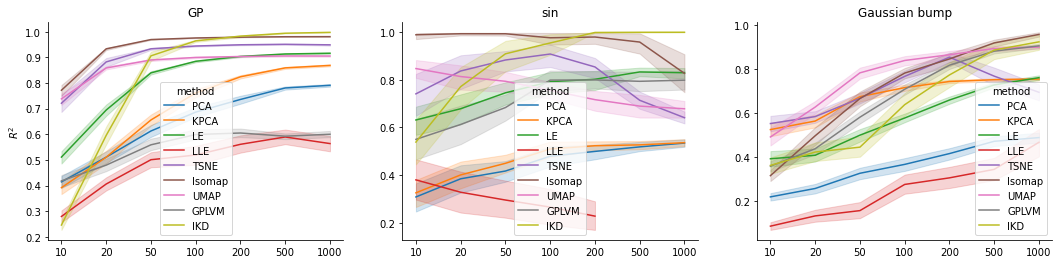

In [122]:
f_list = df.f.unique()
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for i in range(3):
    ax = sns.lineplot(x='d_observation', y='$R^2$', hue='method', data=df[(df.f == f_list[i]).values], ax=axs[i])
    ax.set(xlabel=None, ylabel=None)
    ax.set_title(f_list[i])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
axs[0].set_ylabel('$R^2$')

ValueError: Could not interpret value `time` for parameter `y`

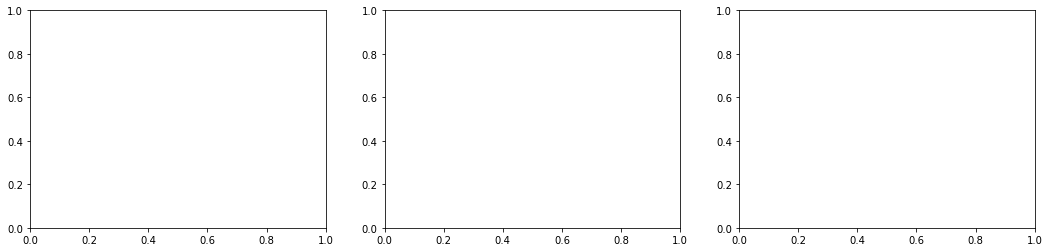

In [120]:
f_list = df.f.unique()
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for i in range(3):
    ax = sns.lineplot(x='d_observation', y='time', hue='method', data=df[(df.f == f_list[i]).values], ax=axs[i])
    ax.set(xlabel=None, ylabel=None)
    ax.set_title(f_list[i])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
axs[0].set_xlabel('runtime')

## Whole experiment

In [17]:
df_list = []
for f in ('GP', 'sin', 'Gaussian bump'):
    for d_observation in (10, 20, 50, 100, 200, 500, 1000):
        for method in ('PCA', 'KPCA', 'LE', 'LLE', 'TSNE', 'Isomap', 'UMAP', 'GPLVM', 'IKD')
            df_list.append(pd.read_csv(f'outputs/{f}_{d_observation}_{method}.csv', index_col=0))
df = pd.concat(df_list, ignore_index=True)
df.d_observation = df.d_observation.astype(str)

result = pd.DataFrame(index=['GP', 'sin', 'Gaussian bump'], columns=['PCA', 'kernel PCA', 'Laplacian eigenmaps', 'IKD', 'IKD-b', 'True'])

In [18]:
d_latent = 3
n_points = 1000
d_observation = 50
seed = 0
rng = np.random.default_rng(seed=seed)
z_true = datasets.generate_latent_from_prior(d, n_points, kernel='autoregressive', variance=6, length_scale=5, bound=6, seed=seed)
cov_true = utils.kernel_cov_generator(z_true, length_scale=3)

x = datasets.gaussian_process_generator(cov_true, d_observation, seed=seed) + rng.normal(scale=0.05, size=(n_points, d_observation))
cov_samp = np.cov(x)
variance_samp = np.mean(cov_samp) * 3.5
cov_samp_th = utils.filt_cov_samp(cov_samp, variance_samp)

z_pca = PCA(n_components=d_latent).fit_transform(x) # pca
z_kernel_pca = KernelPCA(n_components=d_latent, kernel='sigmoid').fit_transform(x) # kernel_pca
z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x)
z_ikd = core.ikd(cov_samp_th, d_latent, variance=variance_samp, length_scale=1)[0]
z_ikd_b = core.ikd_blockwise(cov_samp_th, d_latent, variance=variance_samp, clique_th_or_d_observation=d_observation)

z_pca_aligned = utils.align(z_true, z_pca)
z_kernel_pca_aligned = utils.align(z_true, z_kernel_pca)
z_le_aligned = utils.align(z_true, z_le)
z_ikd_aligned = utils.align(z_true, z_ikd)
z_ikd_b_aligned = utils.align(z_true, z_ikd_b)

result.loc['GP'] = [z_pca_aligned, z_kernel_pca_aligned, z_le_aligned, z_ikd_aligned, z_ikd_b_aligned, z_true]

Too many remaining indices, use nearest neighbors to find all cliques for every points
Clique threshold: 0.3, number of cliques: 1000


In [19]:
d_latent = 1
n_points = 1000
d_observation = 50
seed = 0
rng = np.random.default_rng(seed=seed)
z_true = datasets.generate_latent_from_prior(d_latent, n_points, kernel='autoregressive', variance=6, length_scale=5, bound=6, seed=seed)

omega = rng.uniform(low=-1, high=1, size=(d_observation, d_latent))
phi = rng.uniform(low=-np.pi, high=np.pi, size=(1, d_observation))
x = np.sin(z_true @ omega.T + phi) + rng.normal(scale=0.1, size=(n_points, d_observation))
cov_samp = np.cov(x)

variance_samp = np.mean(cov_samp) * 2
cov_samp_th = utils.filt_cov_samp(cov_samp, variance_samp)


z_pca = PCA(n_components=d_latent).fit_transform(x) # pca
z_kernel_pca = KernelPCA(n_components=d_latent, kernel='cosine').fit_transform(x) # kernel_pca
z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x)
z_ikd = core.ikd(cov_samp_th, d_latent, variance=variance_samp, length_scale=1)[0]
z_ikd_b = core.ikd_blockwise(cov_samp_th, d_latent, variance=variance_samp, clique_th_or_d_observation=0.3)

z_pca_aligned = utils.align(z_true, z_pca)
z_kernel_pca_aligned = utils.align(z_true, z_kernel_pca)
z_le_aligned = utils.align(z_true, z_le)
z_ikd_aligned = utils.align(z_true, z_ikd)
z_ikd_b_aligned = utils.align(z_true, z_ikd_b)

result.loc['sin'] = [z_pca_aligned, z_kernel_pca_aligned, z_le_aligned, z_ikd_aligned, z_ikd_b_aligned, z_true]

Clique threshold: 0.3, number of cliques: 501


In [21]:
d = 2
n_points = 1000
d_observation = 50
seed = 0
rng = np.random.default_rng(seed=seed)
z_true = datasets.generate_latent_from_prior(d, n_points, kernel='autoregressive', variance=6, length_scale=5, bound=6, seed=seed)

cov_true = utils.kernel_cov_generator(z_true)

x = datasets.gaussian_bump_generator(z_true, 100, d_observation, area=6, variance=20, length_scale=1, seed=seed) + rng.normal(scale=0.05, size=(n_latents, d_observation))
cov_samp = np.cov(x)
variance_samp = np.mean(cov_samp) * 2
cov_samp_th = utils.filt_cov_samp(cov_samp, variance_samp)

z_pca = PCA(n_components=d).fit_transform(x) # pca
z_kernel_pca = KernelPCA(n_components=d, kernel='sigmoid').fit_transform(x) # kernel_pca
z_le = SpectralEmbedding(n_components=d).fit_transform(x)
z_ikd = core.ikd(cov_samp_th, d, variance=variance_samp, length_scale=1)[0]
z_ikd_b = core.ikd_blockwise(cov_samp_th, d, variance=variance_samp, clique_th_or_d_observation=d_observation)

z_pca_aligned = utils.align(z_true, z_pca)
z_kernel_pca_aligned = utils.align(z_true, z_kernel_pca)
z_le_aligned = utils.align(z_true, z_le)
z_ikd_aligned = utils.align(z_true, z_ikd)
z_ikd_b_aligned = utils.align(z_true, z_ikd_b)

result.loc['Gaussian bump'] = [z_pca_aligned, z_kernel_pca_aligned, z_le_aligned, z_ikd_aligned, z_ikd_b_aligned, z_true]

Too many remaining indices, use nearest neighbors to find all cliques for every points
Clique threshold: 0.3, number of cliques: 1000


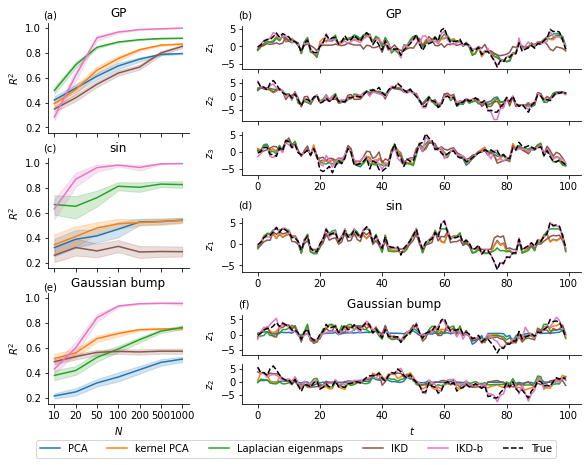

In [22]:
fig = plt.figure(figsize=(8, 6), constrained_layout=True)
color_list = ['C0', 'C1', 'C2', 'C5', 'C6']

subfigs = fig.subfigures(1, 2, width_ratios=[1, 2])
axs = subfigs[0].subplots(3, 1, sharex=True, sharey=True)
for i in range(3):
    ax = sns.lineplot(x='n_attributes', y='r2', hue='method', data=df[df['f'] == ('GP', 'sin', 'Gaussian bump')[i]], ax=axs[i], palette=color_list, legend=False)
    ax.set(xlabel='$N$', ylabel='$R^2$', title=result.index[i])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

subsubfigs = subfigs[1].subfigures(3, 1, height_ratios=[4, 2, 3])
axs = subsubfigs[0].subplots(3, 1, sharex=True)
for i in range(3):
    for j, column in enumerate(result.columns[:-1]):
        axs[i].plot(result.loc['GP', column][:100, i], c=color_list[j])
    axs[i].plot(result.loc['GP', 'True'][:100, i], 'k--')
    axs[i].set_ylabel(f'$z_{i+1}$')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
subsubfigs[0].suptitle('GP')

ax = subsubfigs[1].add_subplot(1, 1, 1)
for i, column in enumerate(result.columns[:-1]):
    ax.plot(result.loc['sin', column][:100, 0], c=color_list[i])
ax.plot(result.loc['sin', 'True'][:100, 0], 'k--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('$z_1$')
subsubfigs[1].suptitle('sin')

axs = subsubfigs[2].subplots(2, 1, sharex=True)
for i in range(2):
    for j, column in enumerate(result.columns[:-1]):
        axs[i].plot(result.loc['Gaussian bump', column][:100, i], c=color_list[j], label=column)
    axs[i].plot(result.loc['Gaussian bump', 'True'][:100, i], 'k--', label='True')
    axs[i].set_ylabel(f'$z_{i+1}$')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
axs[1].set_xlabel('$t$')
subsubfigs[2].suptitle('Gaussian bump')

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.06), ncol=6)

fig.text(0.06, 0.97, '(a)')
fig.text(0.40, 0.97, '(b)')
fig.text(0.06, 0.66, '(c)')
fig.text(0.40, 0.53, '(d)')
fig.text(0.06, 0.34, '(e)')
fig.text(0.40, 0.30, '(f)')

fig.savefig('exp1_Gaussian_noisy_observations.pdf', bbox_inches='tight')